# Predicting Bike Rentals 

## Goal:
**This project will try to predict total number of bikes  people rented in a given hour. Will predict the 'cnt' column using other columns, except for 'casual' and 'registered'. After that, I will create a pipiline to sort out the most significantly features by building Decision Tree from scratch**

## Data:
**Data was donwloaded from <a href='http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset'>here</a>**<br>
**Also, the page contains all header names  meaning which I copied and pasted in the next cell**

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
import math
%matplotlib inline

## Load data & Analysis

In [2]:
df=pd.read_csv("bike_rental_hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Check null values in the data

In [3]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Check into columns' attributes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


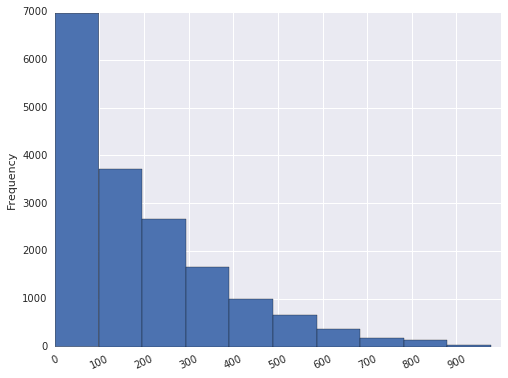

In [5]:
#Make histogram to see distribution of total rentals
def hist_plot(series,start, end, inter):
    plt.figure(figsize=(8,6))
    series.plot.hist(grid=True, xticks=np.arange(start,end,inter), rot=25)
    plt.show()

hist_plot(df['cnt'],0,1000,100)

Check into correlation 

In [6]:
print(df.corr()['cnt'].sort_values(ascending=False))

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64


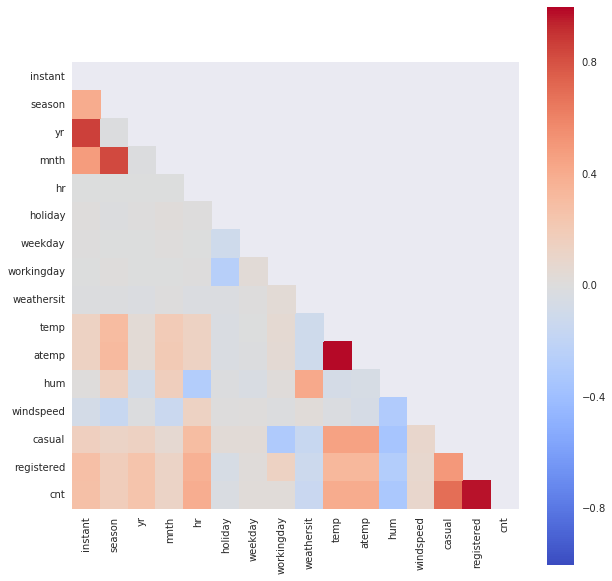

In [7]:
#Visualize the correlation results
plt.figure(figsize=(10,10))
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True
ax=sns.heatmap(df.corr(), 
               cbar=True, 
               cmap='coolwarm', 
               square=True,
               mask=mask)

## Feature Engineering
Transfrom column contains hours information to 4 labors "morning", "afternoon", "evening", and "night"

In [8]:
def hour_transform(hour):
    if hour >= 0 and hour <6:
        return 4
    elif hour >=6 and hour <12:
        return 1
    elif hour >= 12 and hour <=18:
        return 2
    elif hour > 18 and hour <=24:
        return 3

df['time']=df['hr'].apply(hour_transform)

#get count of unique values 
df['time'].value_counts()

2    5103
1    4360
4    4276
3    3640
Name: time, dtype: int64

## Model Errors Comparison 

split data into train/ test

In [11]:
def split_remove(df):
    #Randomly shuffle the index fro dataframe
    shuffled_index=np.random.permutation(df.index)
    df=df.reindex(shuffled_index)
    
    #Remove target column and useless columns here
    features=list(df.columns)
    features.remove("cnt")
    features.remove("casual")
    features.remove("registered")
    features.remove("dteday") 
    
    #Split dataset
    train=df.sample(frac=0.8)
    test=df.loc[~df.index.isin(train.index)]
    
    return features, train, test       

In [12]:
features, train, test=split_remove(df) 

- Linear Model

In [13]:
def linear_error(train, test, features):
    #Initiate a Linear Regressor 
    lr=LinearRegression()
    lr.fit(train[features], train['cnt'])
    predictions=lr.predict(test[features])
    
    #Calculate the mse 
    error=mean_squared_error(test['cnt'], predictions)
    
    print("Linear Regression:", error)

linear_error(train, test, features)

Linear Regression: 17299.826382403793


**MSE for Linear Regression is pretty high, might be due to that if data has a few high rental counts, larger errors are penalized more with MSE, which leads to a higher total error**

- Decision Tree Regression

In [25]:
def deicision_tree_error(train, test, features):
    tree=DecisionTreeRegressor(min_samples_leaf=2)
    tree.fit(train[features], train['cnt'])
    predictions=tree.predict(test[features])
    
    error=mean_squared_error(test['cnt'], predictions)
    train_error=mean_squared_error(tree.predict(train[features]), train['cnt'])
    print("Decision Tree MSE: ", error)
    print("Decision Tree MSE for Train set: ", train_error)


deicision_tree_error(train, test, features)

Decision Tree MSE:  2856.7117296381534
Decision Tree MSE for Train set:  321.7107938334652


**Decision Tree performs way better, but given the huge difference between MSE for train set and MSE values for test set, it might indicates overfitting issues here**

- Random Forest

In [26]:
def random_forest_error(train, test, features):
    #Initiate a random forest regressor
    rf=RandomForestRegressor(min_samples_leaf=5)
    
    #fit / predict
    rf.fit(train[features], train['cnt'])
    predictions=rf.predict(test[features])
    
    #calculate mse error
    error=mean_squared_error(test['cnt'], predictions)
    train_error=mean_squared_error(rf.predict(train[features]), train['cnt'])
    
    print("Decision Tree: ", error)
    print("Decision Tree MSE for Train set: ", train_error)
    
random_forest_error(train, test, features)

Decision Tree:  1896.2587939664877
Decision Tree MSE for Train set:  1111.4453969884278


**Random Forest Outperforms both previous methods. Also, it produces more balanced MSE results on both train/test sets** 

## Most Significant Attribute

Create a pipeline for decision tree /random forest to find the most significant attributes

In [60]:
#First, Calculate the entropy
def calculate_entropy(column):
    #Counts of each unique value in the column
    counts=np.bincount(column)
    
    #get an array of all probabilities
    probabilities=counts/len(column)
    
    entropy=0
    
    #for each probability, add the result to the total entropy
    for prob in probabilities:
        if prob >0:
            entropy += prob*math.log(prob,2)
    return -entropy

In [61]:
calculate_entropy(df['cnt'])

8.88414828957113

In [62]:
#Second find the best variables
def information_gain(df, features, target):
    #calculate original entropy
    original_entropy=calculate_entropy(df[target])
    
    #Find the median of column that will be used for splitting
    column=df[features]
    median=column.median()
    
    #split the data based on median
    left_branch=df[column<=median]
    right_branch=df[column>median]
    
    substract=0
    
    #Add  up all subset entropies
    for subset in [left_branch, right_branch]:
        prob = (subset.shape[0]/df.shape[0])
        substract += prob * calculate_entropy(subset[target])
        
    return original_entropy - substract
    

In [67]:
#Third, find the best column 
def find_best_column(df, features, target):
    information_gain_list=[]
    
    #Calculate and append information gain for each column
    for col in features:
        info_gain=information_gain(df, col, 'cnt')
        information_gain_list.append(info_gain)
    
    highest_index=information_gain_list.index(max(information_gain_list))
    highest_name=features[highest_index]     
    
    return highest_name

In [69]:
find_best_column(df, features, 'cnt')

'time'

## Conclusion

- **Time (hour of day) is most significant variables for bike rental predictions as it generates highest impurity**<br><br>
- **Linear Regression performs worst, decision tree works better but it still tend to be a bit overfitting, RandomForest performs best here, and it tends to be less overfitting, although in this particular case difference is  not that big**